In [3]:
import os
import toml
from tqdm import tqdm
from prettytable import PrettyTable

import torch
from torch import optim
from torch.utils.data import DataLoader

from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer

# Define paths for project folder and for data folder:

In [4]:
PROJECT_PATH = 'PATH_TO_PROJECT'
PATH_TO_DATA = 'PATH_TO_DATA'

In [5]:
os.chdir(PROJECT_PATH)
os.environ["L5KIT_DATA_FOLDER"] = PATH_TO_DATA

In [6]:
# Load config 
cfg = toml.load('config.toml')

# Load data:

In [7]:
MODE = cfg['mode']

dm = LocalDataManager(None)
rasterizer = build_rasterizer(cfg, dm)

if MODE == 'train_sample':
  train_cfg = cfg['sample_data_loader']
if MODE == 'train_full':
  train_cfg = cfg['train_data_loader']
  
print(f'Current mode: {MODE}.')
print('Train params:')
print(train_cfg)

Current mode: train_sample.
Train params:
{'key': 'scenes/sample.zarr', 'batch_size': 32, 'shuffle': True, 'num_workers': 0}


In [8]:
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer, min_frame_future=cfg['min_frame_future'])
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg['shuffle'],
                              batch_size=train_cfg['batch_size'],
                              num_workers=train_cfg['num_workers'])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: you're running with custom min_frame_future of 50
  


# CVAE training:
Training of conditional variational autoencoder to learn distribution P(trajectory | frame, history).


In [9]:
from lyft_motion_prediction.models import CVAE
from lyft_motion_prediction.train.train_cvae import train_cvae

In [10]:
# Define device and criterion
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = cfg['cvae_cfg']['vlb_loss']
print(f'Device: {device}')
print(f'Vlb loss: {criterion}')

Device: cuda:0
Vlb loss: KLD


In [11]:
# Initialize model and optimizer
model = CVAE(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg['train_cvae_params']['lr'])

**CVAE training:**

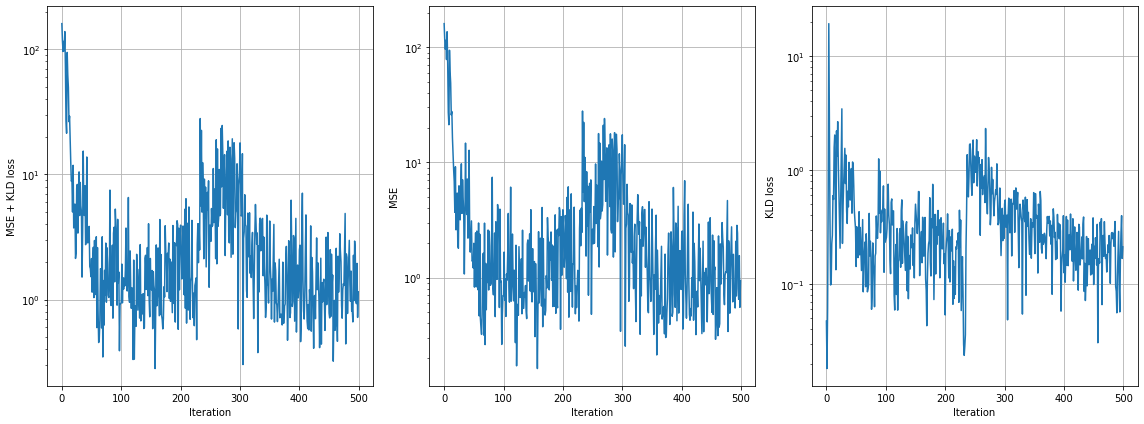

loss: 1.1531764268875122, loss(avg): 5.27846817189455: 100%|██████████| 500/500 [24:51<00:00,  2.98s/it]


In [12]:
train_cvae(model,
           train_dataloader,
           optimizer,
           device,
           cfg,
           plot_mode=True)

# Extractor training:
Training of model that extract trajectories with probabilities defined as `confidences` from samples of P(trajectory | frame, history) distribution sampled form CVAE model.

In [13]:
from lyft_motion_prediction.utils.load_models import *
from lyft_motion_prediction.models import CVAE, TrajectoriesExtractor
from lyft_motion_prediction.train.train_extractor import train_extractor

In [14]:
# Load pretrained model
cvae_model = get_model('CVAE', cfg, device)

In [15]:
# Initialize model and optimizer
extractor_model = TrajectoriesExtractor(cfg).to(device)
optimizer = optim.Adam(extractor_model.parameters(), cfg['train_extractor_params']['lr'])

In [16]:
confidences = cfg['train_extractor_params']['confidences']
confidences = torch.Tensor(confidences).expand(train_cfg['batch_size'], 3).to(device)

**Extractor training:**

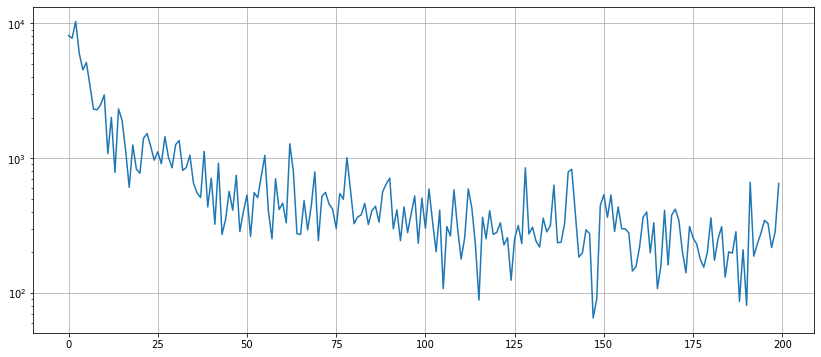

loss: 649.11376953125, loss(avg): 733.6462283706664: 100%|██████████| 200/200 [18:44<00:00,  5.62s/it]


In [18]:
train_extractor(cvae_model,
                extractor_model,
                train_dataloader,
                confidences,
                optimizer,
                device,
                cfg,
                plot_mode=True)